Ordered Nets with Pin Details
Order Net Name  Pin Details (Layer, X, Y)               
--------------------------------------------------
1     net3      
       Pin 1: Layer=0, X=1, Y=2
       Pin 2: Layer=1, X=4, Y=7
       Pin 3: Layer=0, X=8, Y=8
--------------------------------------------------
2     net2      
       Pin 1: Layer=0, X=2, Y=3
       Pin 2: Layer=1, X=6, Y=7
       Pin 3: Layer=0, X=10, Y=9
--------------------------------------------------
3     net1      
       Pin 1: Layer=0, X=1, Y=1
       Pin 2: Layer=0, X=3, Y=3
       Pin 3: Layer=0, X=7, Y=7
       Pin 4: Layer=1, X=9, Y=9
--------------------------------------------------
Routed Nets Summary
Net 'net3':
--------------------------------------------------
  Path 1: [(0, 1, 2), (0, 2, 2), (0, 3, 2), (0, 4, 2), (1, 4, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5), (1, 4, 6), (1, 4, 7)]
  Length for Path 1: 10
  Cost for Path 1: 11
  ******
  Path 2: [(1, 4, 7), (1, 4, 8), (0, 4, 8), (0, 5, 8), (0, 6, 8), (0, 7, 8), (

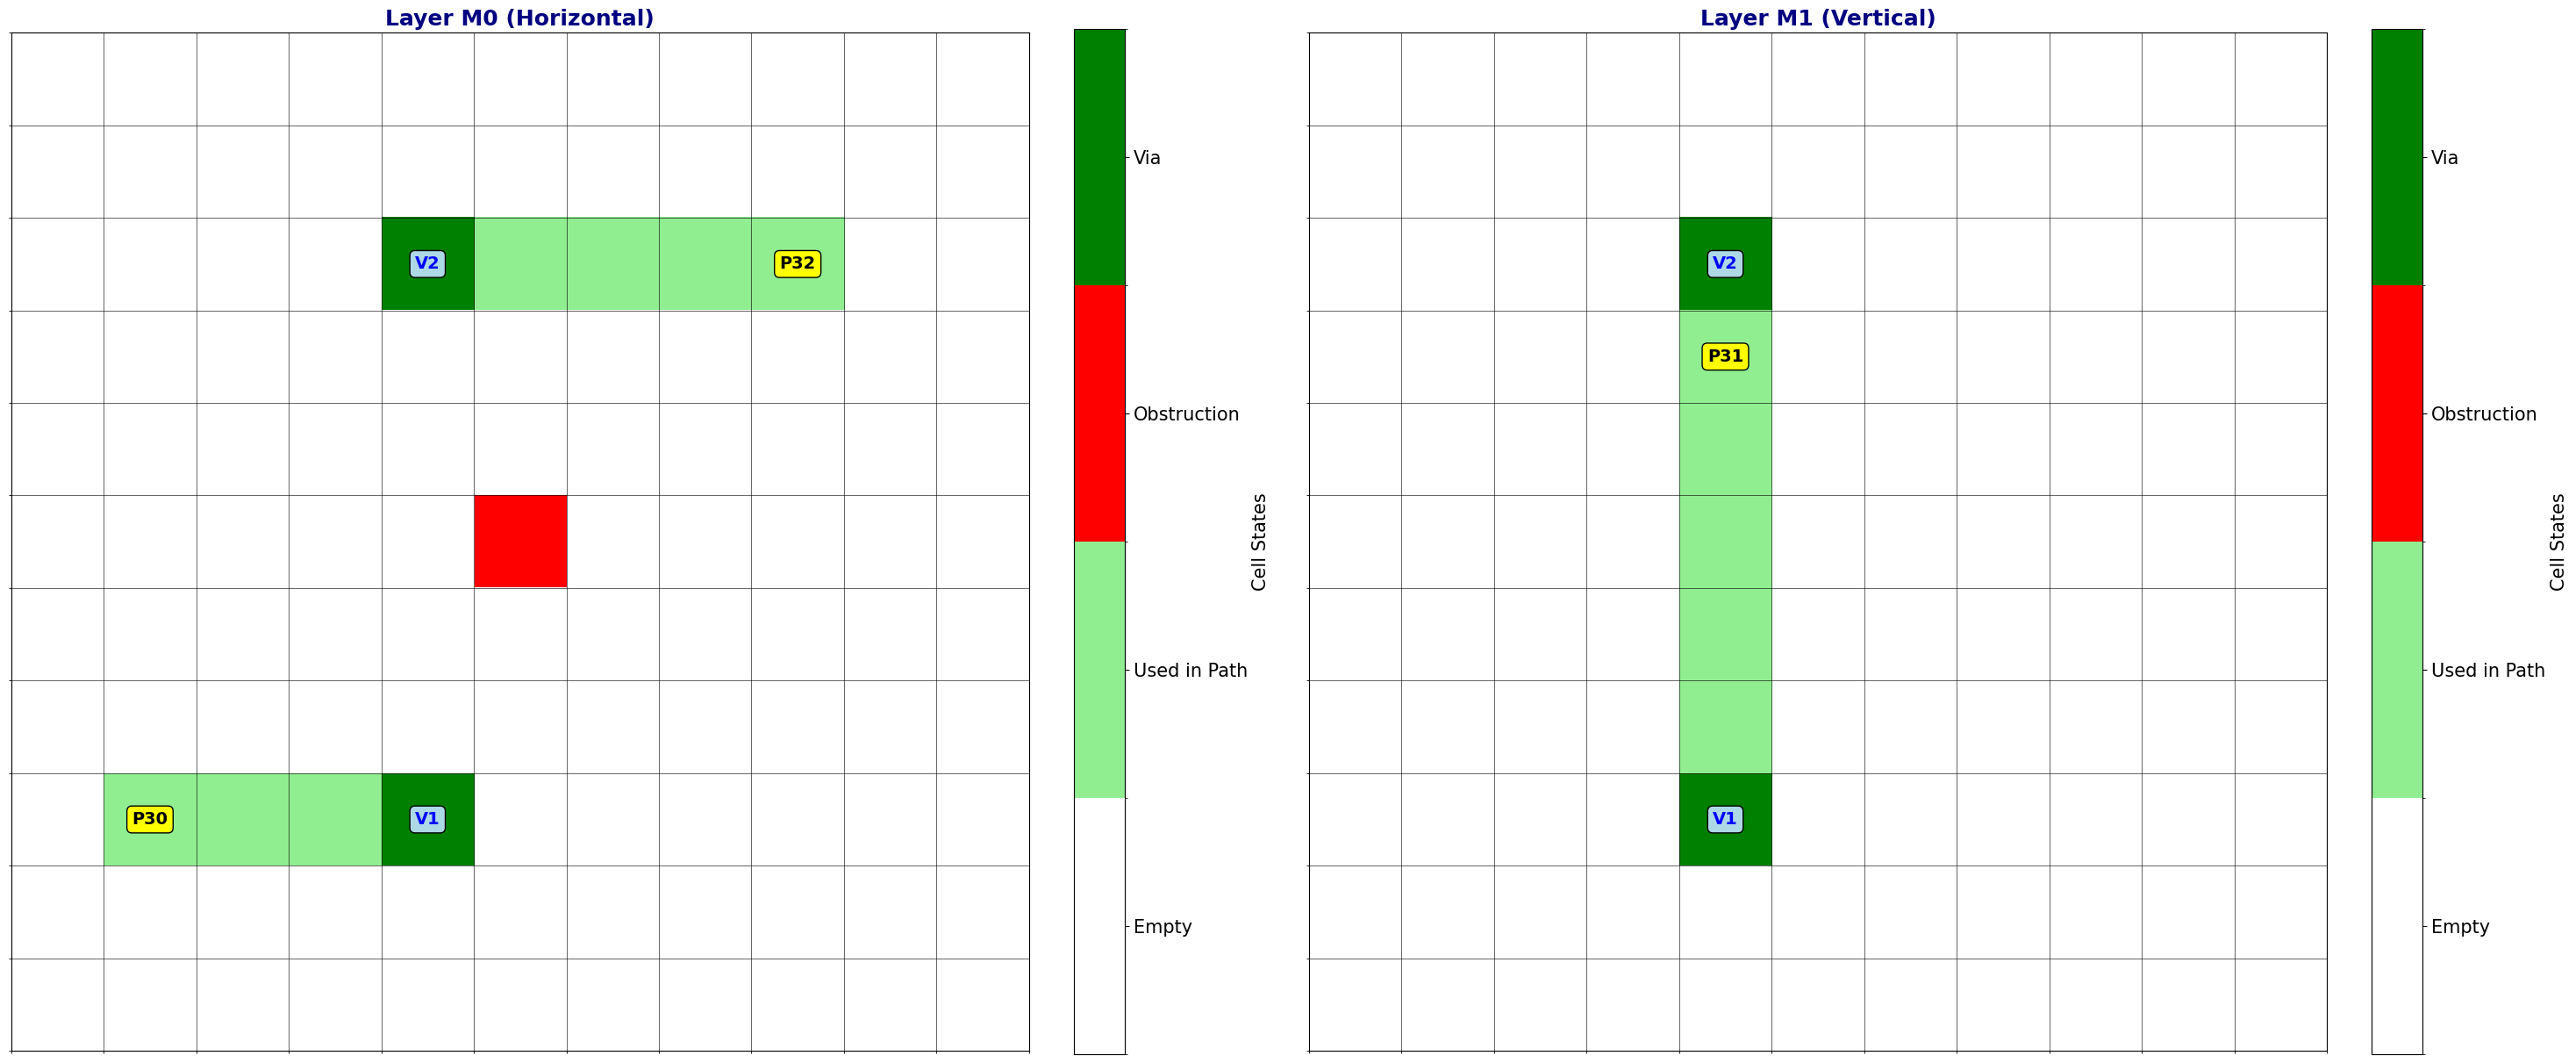

In [62]:
# Global grid representation
import re
import matplotlib.pyplot as plt
import numpy as np
import heapq
from collections import deque
from matplotlib.colors import ListedColormap, BoundaryNorm


# Global variables
grid_dimensions = None
bend_penalty = None
via_penalty = None
obstructions = []
nets = {}
grid = []
num_vias = 0

### Input Parsing ###
def parse_input_file(file_path):
    global grid_dimensions, bend_penalty, via_penalty, obstructions, nets, num_vias

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse the grid dimensions and penalties
    grid_info = list(map(int, lines[0].strip().split(',')))
    grid_dimensions = (grid_info[0], grid_info[1])  # NxM grid
    bend_penalty = grid_info[2]
    via_penalty = grid_info[3]

    # Parse obstructions
    for line in lines[1:]:
        if line.startswith("OBS"):
            match = re.search(r"\((\d+),\s*(\d+),\s*(\d+)\)", line)
            if match:
                obstructions.append((int(match.group(1)), int(match.group(2)), int(match.group(3))))

    # Parse nets
    for line in lines[1:]:
        if line.startswith("net"):
            net_name = line.split(' ')[0]
            net_points = re.findall(r"\((\d+),\s*(\d+),\s*(\d+)\)", line)
            for i, point in enumerate(net_points):
                net_points[i] = (int(point[0]), int(point[1]), int(point[2]))
            for i, point in enumerate(net_points):
                if point in obstructions:
                    print(f"Error: Net '{net_name}' contains an obstruction at {point} and this point will be removed.")
                    net_points.remove(point)
            nets[net_name] = [(int(layer), int(x), int(y)) for layer, x, y in net_points]

### Grid Initialization ###            
def initialize_grid():
    global grid, grid_dimensions, obstructions, nets, num_vias

    # Extract dimensions
    rows, cols = grid_dimensions

    # Create a 3D list for two layers, each initialized with default cost (0 for simplicity)
    grid = [[[{
        'cost': 1,
        'obstruction': False, 
        'used_in_path': False, 
        'pin': False, 
        'via': False, 
        'via_num': 0, 
        'net_num': -1, 
        'pin_num': -1, 
        'path_num': -1
    } for _ in range(cols)] for _ in range(rows)] for _ in range(2)]

    # Mark obstructions
    for layer, x, y in obstructions:
        grid[layer][x][y]['obstruction'] = True
        grid[layer][x][y]['cost'] = float('inf')  # Assign a high cost to obstructions
    
    # Mark pins and assign net/pin numbers
    net_num = 1 
    pin_num = 0 
    for net in nets:
        for layer, x, y in nets[net]:
            grid[layer][x][y].update({'pin': True, 'pin_num': pin_num, 'net_num': net_num})
            pin_num += 1
        pin_num = 0
        net_num += 1  # Increment net number for the next net

### Visualization ###
def visualize_3d_grid_matplotlib(net=None, path=None):
    global grid, grid_dimensions, num_vias

    # Extract grid dimensions
    rows, cols = grid_dimensions

    # Prepare two grid matrices for the layers
    grid_matrix_layer0 = np.zeros((cols, rows), dtype=int)
    grid_matrix_layer1 = np.zeros((cols, rows), dtype=int)

    for layer in range(2):
        for row in range(rows):
            for col in range(cols):
                cell = grid[layer][row][col]
                if cell['used_in_path']:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = 1
                    else:
                        grid_matrix_layer1[col][row] = 1
                else:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = 0
                    else:
                        grid_matrix_layer1[col][row] = 0
                if cell['via']:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = 3
                    else:
                        grid_matrix_layer1[col][row] = 3
                if path:
                    if cell['path_num'] != path:
                        if layer == 0:
                            grid_matrix_layer0[col][row] = 0
                        else:
                            grid_matrix_layer1[col][row] = 0
                if net:
                    if cell['net_num'] != net:
                        if layer == 0:
                            grid_matrix_layer0[col][row] = 0
                        else:
                            grid_matrix_layer1[col][row] = 0
                if cell['obstruction']:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = 2
                    else:
                        grid_matrix_layer1[col][row] = 2

    # Plot both layers
    fig, axes = plt.subplots(1, 2, figsize=(30, 15))

    # Define custom values and colors for the layers
    values = [0, 1, 2, 3]  # The values you want to map to specific colors (0=empty, 1=used_in_path, 2=obstruction)
    colors = ['white', 'lightgreen', 'red', 'green']  # Colors for each value (0=white, 1=green, 2=red)
        
    # Create a ListedColormap and BoundaryNorm for the specific values
    cmap = ListedColormap(colors)
    norm = BoundaryNorm([0, 1, 2, 3, 4], len(values))  # Normalizing over a range from 0 to 3 to cover [0, 1, 2]

    # Plot Layer 0 with the custom colormap and norm
    im0 = axes[0].imshow(grid_matrix_layer0, cmap=cmap, norm=norm, origin='lower')
    axes[0].set_title("Layer M0 (Horizontal)", fontsize=18, fontweight='bold', color='navy', loc='center')  # Enhanced title styling
    axes[0].set_xticks(np.arange(-0.5, cols, 1), minor=True)
    axes[0].set_yticks(np.arange(-0.5, rows, 1), minor=True)
    axes[0].grid(which="minor", color="black", linestyle='-', linewidth=0.6, alpha=0.7)  # Slightly thicker grid lines
    axes[0].set_aspect('equal')
    axes[0].set_xticks([])  # Remove x-ticks
    axes[0].set_yticks([])  # Remove y-ticks

    # Add 'P' and 'V' annotations for Layer 0
    for row in range(rows):
        for col in range(cols):
            cell = grid[0][col][row]  # Access the cell in Layer 0
            if path:
                if cell['path_num'] != path:
                    continue
            if net:
                if cell['net_num'] != net:
                    continue
            via_number = cell.get('via_num', '')  # Get the via number from the cell
            pin_number = cell.get('pin_num', '')  # Get the pin number from the cell
            net_number = cell.get('net_num', '')  # Get the net number from the cell
            # Check for conditions and annotate accordingly
            if cell.get('pin', False) and cell.get('via', False):  # Both pin and via
                via_number = cell.get('via_num', '')  # Get the via number from the cell
                
                # Annotate 'P' and 'V' separately but side by side with more space
                # Position the 'P' annotation in the left part of the cell
                axes[0].text(col-0.2, row, f'P{net_number}{pin_number}', color='black', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.3'))
                
                # Position the 'V' annotation in the right part of the cell
                axes[0].text(col+0.2, row, f'V{via_number}', color='blue', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))
                    
            elif cell.get('pin', False):  # Only pin
                axes[0].text(col, row, f'P{net_number}{pin_number}', color='black', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.3'))
            elif cell.get('via', False):  # Only via
                via_number = cell.get('via_num', '')  # Get the via number from the cell
                axes[0].text(col, row, f"V{via_number}", color='blue', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))

    # Add colorbar to the first plot to show what the colors represent
    cbar = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5])
    cbar.set_ticklabels(['Empty', 'Used in Path', 'Obstruction', 'Via'], fontsize=15)
    cbar.set_label('Cell States', fontsize=15)

    # Now, plot Layer 1 with similar enhancements
    im1 = axes[1].imshow(grid_matrix_layer1, cmap=cmap, norm=norm, origin='lower')
    axes[1].set_title("Layer M1 (Vertical)", fontsize=18, fontweight='bold', color='navy', loc='center')  # Enhanced title styling
    axes[1].set_xticks(np.arange(-0.5, cols, 1), minor=True)
    axes[1].set_yticks(np.arange(-0.5, rows, 1), minor=True)
    axes[1].grid(which="minor", color="black", linestyle='-', linewidth=0.6, alpha=0.7)  # Slightly thicker grid lines
    axes[1].set_aspect('equal')
    axes[1].set_xticks([])  # Remove x-ticks
    axes[1].set_yticks([])  # Remove y-ticks
    
    # Add 'P' and 'V' annotations for Layer 1
    for row in range(rows):
        for col in range(cols):
            cell = grid[1][col][row]  # Access the cell in Layer 1
            if path:
                if cell['path_num'] != path:
                    continue
            if net:
                if cell['net_num'] != net:
                    continue
            via_number = cell.get('via_num', '')  # Get the via number from the cell
            pin_number = cell.get('pin_num', '')  # Get the pin number from the cell
            net_number = cell.get('net_num', '')  # Get the net number from the cell
            # Check for conditions and annotate accordingly
            if cell.get('pin', False) and cell.get('via', False):  # Both pin and via

                
                # Annotate 'P' and 'V' separately but side by side with more space
                # Position the 'P' annotation in the left part of the cell
                axes[1].text(col-0.2, row, f'P{net_number}{pin_number}', color='black', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.3'))
                
                # Position the 'V' annotation in the right part of the cell
                axes[1].text(col+0.2, row, f'V{via_number}', color='blue', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))
                    
            elif cell.get('pin', False):  # Only pin
                axes[1].text(col, row, f'P{net_number}{pin_number}', color='black', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.3'))
            elif cell.get('via', False):  # Only via
                via_number = cell.get('via_num', '')  # Get the via number from the cell
                axes[1].text(col, row, f"V{via_number}", color='blue', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))

    # Add colorbar to the second plot to show what the colors represent
    cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cbar1.set_ticks([0.5, 1.5, 2.5, 3.5])
    cbar1.set_ticklabels(['Empty', 'Used in Path', 'Obstruction', 'Via'], fontsize=15) 
    cbar1.set_label('Cell States', fontsize=15)

    # Adjust layout to ensure titles and labels don't overlap
    fig.tight_layout(pad=3)

    plt.show()


def order_nets_advanced(nets):
    global grid, grid_dimensions, obstructions, bend_penalty, via_penalty
    def calculate_manhattan_distance(pins):
        if len(pins) < 2:
            return 0
        # Calculate the Manhattan distance between the furthest pins
        distances = [
            abs(pin1[1] - pin2[1]) + abs(pin1[2] - pin2[2])
            for i, pin1 in enumerate(pins)
            for pin2 in pins[i+1:]
        ]
        return max(distances)
    
    def estimate_net_cost(pins):
        total_cost = 0
        for i in range(len(pins) - 1):
            pin1, pin2 = pins[i], pins[i + 1]
            manhattan_distance = abs(pin1[1] - pin2[1]) + abs(pin1[2] - pin2[2])
            bends = abs(pin1[1] - pin2[1]) > 0 and abs(pin1[2] - pin2[2]) > 0
            via = pin1[0] != pin2[0]
            
            # Add penalties for bends and vias
            total_cost += manhattan_distance
            if bends:
                total_cost += bend_penalty
            if via:
                total_cost += via_penalty
            
            # Add cost if passing through obstacles
            for x in range(min(pin1[1], pin2[1]), max(pin1[1], pin2[1]) + 1):
                for y in range(min(pin1[2], pin2[2]), max(pin1[2], pin2[2]) + 1):
                    if (pin1[0], x, y) in obstructions or (pin2[0], x, y) in obstructions:
                        total_cost += 100  # Arbitrary high penalty for obstacles
        return total_cost
    
    def net_priority(net):
        name, pins = net
        manhattan_distance = calculate_manhattan_distance(pins)
        pin_count = len(pins)
        estimated_cost = estimate_net_cost(pins)
        # Lower cost is higher priority; sort by cost, distance, and pin count
        return (estimated_cost, -manhattan_distance, -pin_count)
    
    return sorted(nets.items(), key=net_priority)


def find_path(grid, sources, targets, bend_penalty, via_penalty,visited_num):
    global num_vias
    rows = len(grid[0])
    cols = len(grid[0][0])

    # Directions for neighbors: (layer, dx, dy)
    directions = {
        0: [(0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0)],  # Horizontal layer
        1: [(0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0)]   # Vertical layer
    }
    
    # Preferred directions for each layer
    preferred = {
        0: (1, 0),  # Horizontal: (dx, dy)
        1: (0, 1)   # Vertical: (dx, dy)
    }
    counter = 0

    # Priority queue: (cost, (layer, x, y), previous_direction)
    pq = []
    dist = {}
    paths = {}
    potentials = []
    visit_counter = {}
    for source in sources:
        heapq.heappush(pq, (0, source, None,(-1,-1,-1)))  # Each source starts with a cost of 0
        dist[source] = {}
        dist[source][(-1,-1,-1)] = 0  # Initialize the distance for each source
        paths[source] = {}  # Initialize the path for each source
        paths[source][(-1,-1,-1)] = []  # Initialize the path for each source
        visit_counter[source] = 0  # Source starts with zero visits

    # visited = set()
    target_set = set(targets)
    while pq:
        # Pop the cell with the smallest cost
        current_cost, (layer, x, y), prev_direction, node_parent = heapq.heappop(pq)
        # Increment the visit counter
        visit_counter[(layer, x, y)] = visit_counter.get((layer, x, y), 0) + 1

        # Stop if the node has been visited more than 3 times
        if visit_counter[(layer, x, y)] > visited_num:
            continue

        # if (layer, x, y) in visited:
        #     continue
        # visited.add((layer, x, y))
        # Stop if we reach the target
        if (layer, x, y) in target_set:
            counter += 1 
            # print("Target reached")
            # print("Cost is ",current_cost)
            # Reconstruct the path from the paths dictionary
            path = []
            path = path + paths[(layer,x,y)][node_parent]
            path.append((layer, x, y))
            # before_source = path[0]
            # path = path + paths[before_source][]


            potentials.append((path[::-1],dist[(layer, x, y)][node_parent]))
            # if counter >= 5:
            #     break
            continue
        
        for dlayer, dx, dy in directions[layer]:
            nx, ny = x + dx, y + dy
            nlayer = layer + dlayer
            if visit_counter.get((nlayer, nx, ny), 0) >= visited_num:
                continue
            # Check boundaries and obstructions
            if 0 <= nx < rows and 0 <= ny < cols and 0 <= nlayer < 2 and not grid[nlayer][nx][ny]['obstruction'] and not grid[nlayer][nx][ny]['used_in_path'] and not (grid[nlayer][nx][ny]['pin'] and not (nlayer, nx, ny) in targets):


                # Calculate the cost to move to the neighbor
                move_cost = grid[nlayer][nx][ny]['cost']
                normal_cost = dist[(layer, x, y)][node_parent] + move_cost
                heuristic_cost = current_cost + move_cost

                # Add bend penalty if direction changes from preferred direction
                if dlayer==0:
                    preferred_dx, preferred_dy = preferred[layer]
                    if (dx, dy) != (preferred_dx, preferred_dy):
                        heuristic_cost += bend_penalty
                        normal_cost += bend_penalty
                        
                # Add via penalty if transitioning layers
                if dlayer != 0:
                    heuristic_cost += via_penalty
                    normal_cost += via_penalty
                if (nlayer, nx, ny) == node_parent:
                    continue
                # Update distance and add to priority queue if this path is better
                if (nlayer, nx, ny) not in dist:
                    dist[(nlayer, nx, ny)] = {}
                if (layer, x, y) not in dist[(nlayer, nx, ny)]:
                    dist[(nlayer, nx, ny)][(layer, x, y)] = float('inf') 
                if (nlayer, nx, ny) not in paths:
                    paths[(nlayer, nx, ny)] = {}
                if (layer, x, y) not in paths[(nlayer, nx, ny)]:
                    paths[(nlayer, nx, ny)][(layer, x, y)] = []
                # print("node is ",(layer,x,y))
                heuristic_cost += min(abs(nx - tx) + abs(ny - ty) for _, tx, ty in targets)

                paths[(nlayer, nx, ny)][(layer,x,y)] = paths[(layer,x,y)][node_parent]+[(layer,x,y)]
                dist[(nlayer, nx, ny)][(layer,x,y)] = normal_cost

                heapq.heappush(pq, (heuristic_cost, (nlayer, nx, ny), (dx, dy),(layer,x,y)))

    if potentials:
        # print("potentials size is ", potentials.__len__())
        # Find the path with the lowest cost
        best_path, cost = min(potentials, key=lambda x: x[1])
         # first of the path is the target, then its parent, then its parent's parent, and so on until we reach the source
        for i, cell in enumerate(best_path[:-1]):  # Exclude the last element to avoid out-of-bounds indexing
            grid[cell[0]][cell[1]][cell[2]]['used_in_path'] = True
            previous = best_path[i + 1]  # Get the next cell in the path
            if cell[0] != previous[0]:  # Check for layer transition
                grid[cell[0]][cell[1]][cell[2]]['via'] = True
                num_vias += 1
                grid[cell[0]][cell[1]][cell[2]]['via_num'] = num_vias
                grid[previous[0]][previous[1]][previous[2]]['via'] = True
                grid[previous[0]][previous[1]][previous[2]]['via_num'] = num_vias
            
        source = best_path[-1]
            # Append the last cell in the path (source or last step)
        grid[source[0]][source[1]][source[2]]['used_in_path'] = True
        target = best_path[0]
        parent_of_target = best_path[1]
        # Handle the last cell (target) for via marking
        if target[0] != parent_of_target[0]:  # If target has a layer transition
            grid[target[0]][target[1]][target[2]]['via'] = True
        else:
            grid[target[0]][target[1]][target[2]]['via'] = False  # No transition at the last cell
            
        return (best_path[::-1], target, cost)

    # If we reach here, the target is unreachable
    return ([], None, -1)


def route_nets(grid, nets, bend_penalty, via_penalty):
    # Order nets by heuristic
    ordered_nets = order_nets_advanced(nets)
    # print(ordered_nets) in a neat way

    print("=" * 50)
    print("Ordered Nets with Pin Details")
    print("=" * 50)

    print(f"{'Order':<6}{'Net Name':<10}{'Pin Details (Layer, X, Y)':<40}")
    print("-" * 50)

    for i, (net_name, pins) in enumerate(ordered_nets, start=1):
        print(f"{i:<6}{net_name:<10}")
        for j, (layer, x, y) in enumerate(pins, start=1):
            print(f"       Pin {j}: Layer={layer}, X={x}, Y={y}")
        print("-" * 50)

    print("=" * 50)
        

    # Store results
    net_paths = {}
    
    costs = {}
    
    for net_name, pins in ordered_nets:
        path_num = 0
        net_num = list(nets.keys()).index(net_name) + 1
        # Check if the pins list is empty
        if not pins:
            print(f"Error: No pins for net '{net_name}', skipping routing.")
            continue  # Skip this net if it has no pins
        
        paths = []
        pins_covered_map = {pin: False for pin in pins}
        
        pins_covered_map[pins[0]] = True  # Safe now to access pins[0]
        unreached_targets = [key for key, value in list(pins_covered_map.items())[1:] if not value]
        sources = set([pins[0]])

        while not all(pins_covered_map.values()):
            path, target, cost = find_path(grid, list(sources), unreached_targets, bend_penalty, via_penalty, 1)
            if not path:
                print(f"Error: Unable to find a path for net '{net_name}'.")
                break
            unreached_targets.remove(target)
            paths.append(path)
            for cell in path:
                grid[cell[0]][cell[1]][cell[2]]['path_num'] = path_num
                grid[cell[0]][cell[1]][cell[2]]['net_num'] = net_num
            # store the cost of the path of the net
            val = (net_num, path_num)
            costs[val] = cost
            path_num += 1
            pins_covered_map[target] = True

            sources = set(list(sources) + path)

        # Store the path for the net    
        net_paths[net_name] = paths

    return net_paths, costs


if __name__ == "__main__":
    input_file = "input.txt"  # Replace with your input file path
    parse_input_file(input_file)  # Parse the input file
    initialize_grid()  # Initialize the 3D grid
    # Route the nets
    routed_nets, costs = route_nets(grid, nets, bend_penalty, via_penalty)


    print("=" * 50)
    print("Routed Nets Summary")
    print("=" * 50)

    longest_route = 0
    total_wire_length = 0
    longest_net = ""
    longest_net_length = 0
    longest_path_number = 0  # To track the path number of the longest route

    for net_name, paths in routed_nets.items():
        net_length = 0
        print(f"Net '{net_name}':")
        net_num = int(net_name[-1])

        print("-" * 50)
        for i, path in enumerate(paths):
            path_length = len(path)
            print(f"  Path {i+1}: {path}")
            print(f"  Length for Path {i+1}: {path_length}")
            net_length += path_length
            if path_length > longest_route:
                longest_route = path_length
                longest_net = net_name
                longest_path_number = i + 1  # Path numbers are 1-based
            print(f"  Cost for Path {i+1}: {costs[(net_num, i)]}")
            print("  ******")
        print(f" Total Wire Length for '{net_name}': {net_length}")
        print(f" Total Cost for '{net_name}': {sum(costs[(net_num, i)] for i in range(len(paths)))}")
        print("-" * 50)
        total_wire_length += net_length
        if net_length > longest_net_length:
            longest_net_length = net_length

    print("\nSummary")
    print("=" * 50)
    print(f"Longest Route Length: {longest_route}")
    print(f"Net with Longest Route: '{longest_net}'")
    print(f"Path Number of Longest Route: {longest_path_number}")
    print(f"Total Wire Length Across All Nets: {total_wire_length}")
    print("=" * 50)
    # print costs
    visualize_3d_grid_matplotlib(net=3)